In [ ]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# CSV dosyasını oku
df = pd.read_csv("addiction_population_data.csv")

# Hedef sütun oluştur: 5'ten fazla deneme yapanları 'Bağımlı' say
df["Addiction"] = ((df["attempts_to_quit_smoking"] >= 5) & 
                   (df["attempts_to_quit_drinking"] >= 5)).astype(int)

# Kategorik verileri sayılara çevir
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])



Decision Tree Sonuçları
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       437
           1       1.00      1.00      1.00       163

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



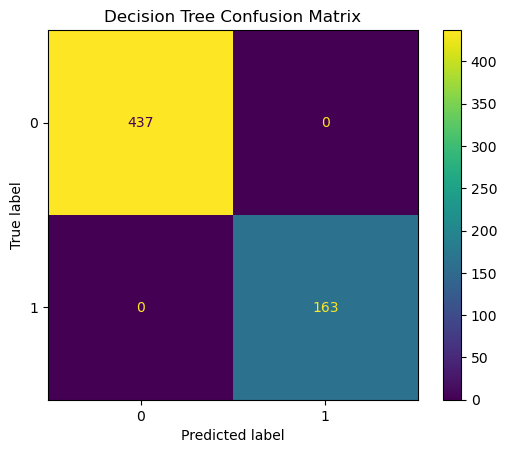


K-Nearest Neighbors Sonuçları
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       437
           1       0.81      0.54      0.65       163

    accuracy                           0.84       600
   macro avg       0.83      0.75      0.77       600
weighted avg       0.84      0.84      0.83       600



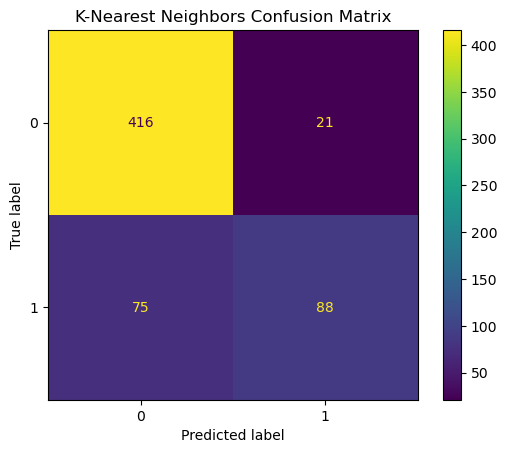


Naive Bayes Sonuçları
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       437
           1       1.00      0.77      0.87       163

    accuracy                           0.94       600
   macro avg       0.96      0.88      0.91       600
weighted avg       0.94      0.94      0.93       600



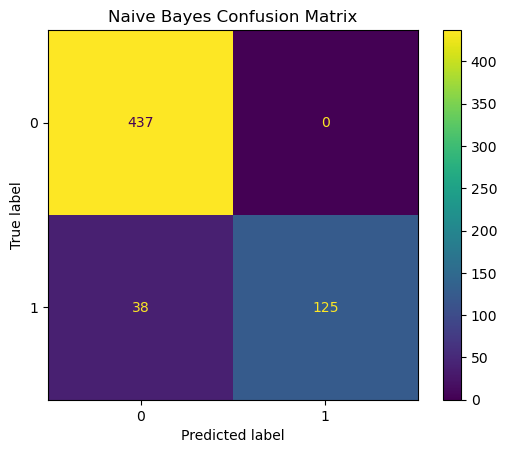

In [6]:
# Özellikleri ve hedefi ayır
X = df.drop(["id", "name", "Addiction"], axis=1)
y = df["Addiction"]

# Veriyi ölçekle
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# %80 eğitim, %20 test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model değerlendirme fonksiyonu
def evaluate_model(model, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Sonuçları")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
evaluate_model(dt, "Decision Tree")

# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
evaluate_model(knn, "K-Nearest Neighbors")

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
evaluate_model(nb, "Naive Bayes")


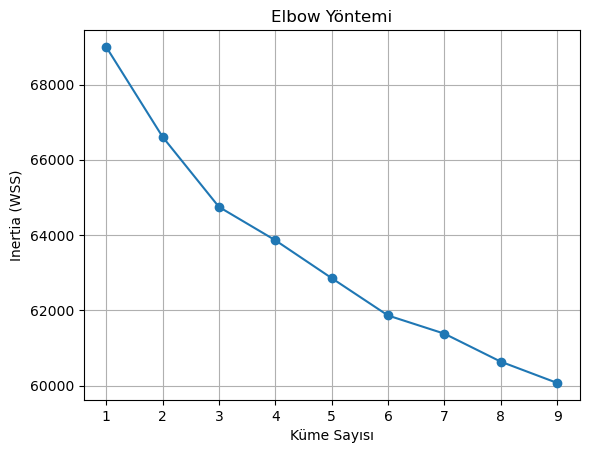

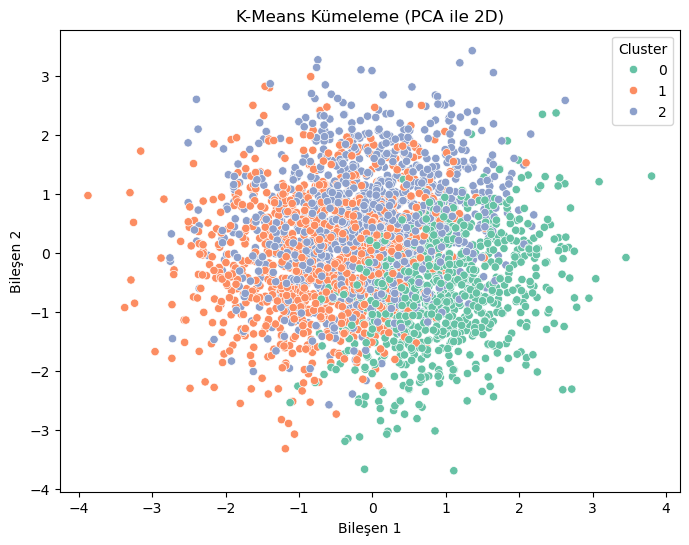

,id,name,age,gender,country,city,education_level,employment_status,annual_income_usd,marital_status,...,attempts_to_quit_drinking,has_health_issues,mental_health_status,exercise_frequency,diet_quality,sleep_hours,bmi,social_support,therapy_history,Addiction
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1514.907522,1495.170160,40.314427,1.528977,131.966708,1110.683107,3.491985,1.701603,90406.672010,2.181258,...,4.371147,0.517879,0.970407,1.803946,0.981504,6.301726,26.853514,1.721332,1.012330,0.341554
1,1458.190654,1470.818692,48.542991,0.832710,115.211215,1412.829907,2.788785,2.105607,99261.802804,2.003738,...,4.700000,1.000000,1.016822,1.321495,1.000935,6.476449,24.508692,1.484112,0.943925,0.206542
2,1530.514745,1456.569258,49.443253,0.782842,117.184093,1436.336014,2.910634,2.149240,104720.816801,2.043789,...,4.514745,0.000000,0.973190,1.416443,1.097408,6.586863,24.582574,1.326184,1.078642,0.202860


In [7]:
# Elbow yöntemi ile ideal küme sayısı
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel("Küme Sayısı")
plt.ylabel("Inertia (WSS)")
plt.title("Elbow Yöntemi")
plt.grid(True)
plt.show()

# 3 küme ile K-Means uygulaması
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# PCA ile görselleştir
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=df["Cluster"], palette="Set2")
plt.title("K-Means Kümeleme (PCA ile 2D)")
plt.xlabel("Bileşen 1")
plt.ylabel("Bileşen 2")
plt.show()

# Küme analiz tablosu
df.groupby("Cluster").mean(numeric_only=True)


In [8]:
# Sadece ilişkisel verilerle çalışalım (basitleştirme için)
df_assoc = df[["gender", "country", "education_level", "employment_status", 
               "has_health_issues", "mental_health_status", "Addiction"]]

# Kategorik değerleri stringe çevir
df_assoc = df_assoc.astype(str)

# Her satırı işlem listesine dönüştür
transactions = df_assoc.values.tolist()

# Transaction Encoder kullan
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori algoritması
frequent_itemsets = apriori(df_trans, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# İlk 10 kural
rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)


,antecedents,consequents,support,confidence,lift
0,(1),(0),0.708000,0.908469,0.978251
1,(0),(1),0.708000,0.762383,0.978251
2,(2),(0),0.650333,0.916393,0.986783
3,(0),(2),0.650333,0.700287,0.986783
4,(3),(0),0.280667,0.907328,0.977022
5,(4),(0),0.286667,0.911017,0.980995
6,(5),(0),0.146333,0.928118,0.999410
7,(6),(0),0.130000,0.906977,0.976644
8,(False),(0),0.468000,0.929801,1.001222
9,(0),(False),0.468000,0.503948,1.001222
